In [ ]:
:orphan:

In [27]:
from katsu.katsu_math import set_backend_to_jax
set_backend_to_jax()
from katsu.katsu_math import (
    np,
    broadcast_kron,
    condition_number
)
from katsu.mueller import(
    linear_diattenuator,
    linear_retarder
)
import numpy as tnp
import matplotlib.pyplot as plt

Exploring option of using an activation function to soft-constrain the PSG / PSA angles. Doesn't really seem to settle into a good solution.

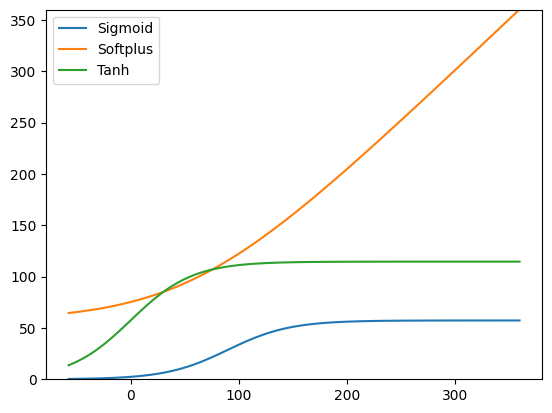

In [28]:
def sigmoid_activation(x, a=1, x0=0, y0=0):
    x = x - x0
    return (1 / (1 + np.exp(-a * x))) + y0

def softplus_activation(x, a=1, x0=1, y0=1):
    x = x - x0
    arg = 1 + np.exp(a * x)
    return np.log(arg) + y0

def tanh_activation(x, a=1, x0=1, y0=1):
    x = x - x0
    return (2 / (1 + np.exp(-2 * a * x)) - 1 + y0)


x = np.linspace(-1, 2 * np.pi, 100)
rtod =  np.degrees(1)
plt.figure()
plt.plot(x * rtod, sigmoid_activation(x, a=2, x0=np.pi/2) * rtod, label='Sigmoid')
plt.plot(x * rtod, softplus_activation(x, a=1, x0=1) * rtod, label='Softplus')
plt.plot(x * rtod, tanh_activation(x, a=1, x0=0) * rtod, label='Tanh')
plt.legend()
plt.ylim(0, 360)
plt.show()

In [29]:
np.degrees(1)

Array(57.29578, dtype=float32, weak_type=True)

# Building the Forward Model
- Number of measurements
- Angular rotation increment of PSG Retarder
- Retardance of PSG Retarder
- Angular rotation increment of PSA Retarder
- Retardance of PSA Retarder
- Fixed angle of PSG polarizer
- Fixed angle of PSA polarizer

In [4]:
Nmeas = 20.
th_g = np.radians(10.)
ret_g = 2 * np.pi / 3
th_a = np.radians(25.)
ret_a = 2 * np.pi / 3
th_pol_g = 0.
th_pol_a = np.pi / 2

In [5]:
def fwd_cond(x):
    """Forward model that returns condition number of data reduction matrix

    Parameters
    ----------
    x : list or 1D array
        coefficient vector
    """

    # Load elements from coefficient vector
    Nmeas = int(x[0])
    th_g = tanh_activation(x[1], x0=1)
    ret_g = x[2]
    th_a = tanh_activation(x[3], x0=1) * (2.5/2)
    ret_a = x[4]
    th_pol_g = x[5]
    th_pol_a = x[6]

    psg_angular_steps = np.linspace(0, Nmeas * th_g, Nmeas)
    psa_angular_steps = np.linspace(0, Nmeas * th_a, Nmeas)

    # set up DRRP, assume ideal polarizer
    psg_pol = linear_diattenuator(th_pol_g, 0, shape=[Nmeas])
    psg_wvp = linear_retarder(psg_angular_steps, ret_g, shape=[Nmeas])

    psa_wvp = linear_retarder(psa_angular_steps, ret_a, shape=[Nmeas])
    psa_pol = linear_diattenuator(th_pol_a, 0, shape=[Nmeas])

    Mg = psg_wvp @ psg_pol
    Ma = psa_pol @ psa_wvp

    PSA = Ma[..., 0, :]
    PSG = Mg[..., :, 0]

    # polarimetric data reduction matrix, flatten Mueller matrix dimension
    Wmat = broadcast_kron(PSA[..., np.newaxis], PSG[..., np.newaxis])
    Wmat = Wmat.reshape([*Wmat.shape[:-2], 16])
    Winv = np.linalg.pinv(Wmat)

    return condition_number(Winv)

In [6]:
x0 = [Nmeas, th_g, ret_g, th_a, ret_a, th_pol_g, th_pol_a] 
cond = fwd_cond(x0)

In [7]:
cond

Array(201.27121, dtype=float32)

In [8]:
from jax import jacrev
rev_cond = jacrev(fwd_cond)

In [9]:
rev_cond(x0)

[Array(0., dtype=float32, weak_type=True),
 Array(-14231.451, dtype=float32, weak_type=True),
 Array(-45.941887, dtype=float32, weak_type=True),
 Array(12794.288, dtype=float32, weak_type=True),
 Array(112.361206, dtype=float32, weak_type=True),
 Array(52.57434, dtype=float32, weak_type=True),
 Array(-126.84468, dtype=float32, weak_type=True)]

In [10]:
cond_fg = lambda x: (fwd_cond(x), rev_cond(x))

In [11]:
cond_fg(x0)

(Array(201.27121, dtype=float32),
 [Array(0., dtype=float32, weak_type=True),
  Array(-14231.451, dtype=float32, weak_type=True),
  Array(-45.941887, dtype=float32, weak_type=True),
  Array(12794.288, dtype=float32, weak_type=True),
  Array(112.361206, dtype=float32, weak_type=True),
  Array(52.57434, dtype=float32, weak_type=True),
  Array(-126.84468, dtype=float32, weak_type=True)])

In [12]:
from scipy.optimize import minimize

In [13]:
number_of_measurements = np.arange(20,110,10)
options = {'maxiter': 300}
condition_num = []
psg_retardance = []
psg_rotation = []
psa_retardance = []
psa_rotation = []
convergence = []

for Nmeas in number_of_measurements:

    # Update number of measurements
    x0 = [Nmeas, th_g, ret_g, th_a, ret_a, th_pol_g, th_pol_a] 
    
    # run optimization
    results = minimize(cond_fg, x0=x0, method='L-BFGS-B', jac=True,
                    options=options)
    
    # save condition number, retardances
    condition_num.append(results.fun)
    psg_rotation.append(tanh_activation(results.x[1], x0=1))
    psg_retardance.append(results.x[2])
    psa_rotation.append(tanh_activation(results.x[3], x0=1) * 2.5 / 2)
    psa_retardance.append(results.x[4])
    convergence.append(results.success)


In [14]:
psg_retardance_deg = [np.degrees(r) for r in psg_retardance]
psa_retardance_deg = [np.degrees(r) for r in psa_retardance]
psg_rotation_deg = [np.degrees(r) for r in psg_rotation]
psa_rotation_deg = [np.degrees(r) for r in psa_rotation]

Condition number for optimal retardance of 127 deg is 19.3

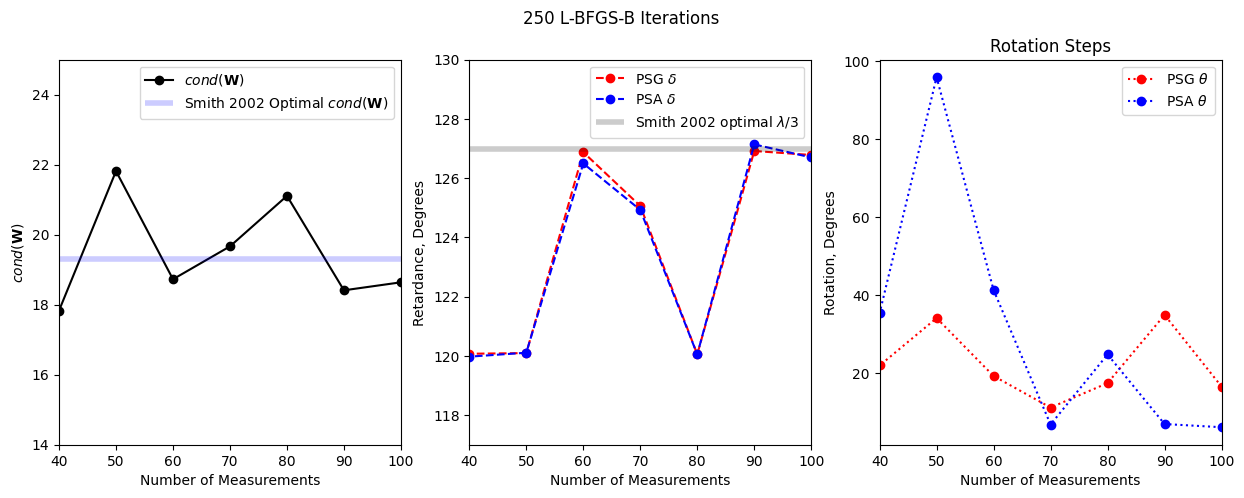

In [26]:
plt.figure(figsize=[15,5])
plt.subplot(131)
plt.plot(number_of_measurements, condition_num, label=r'$cond(\mathbf{W})$', marker='o', color='black')
plt.hlines(19.3, 20, 100, color='b', linewidth=4, alpha=0.2, label='Smith 2002 Optimal '+r'$cond(\mathbf{W})$')
plt.xlabel('Number of Measurements')
plt.ylabel(r'$cond(\mathbf{W})$')
plt.ylim(14, 25)
plt.xlim(40, 100)

# mark places where convergence failed
for n, cv in zip(number_of_measurements, convergence):
    if cv == False:
        plt.vlines(n, 0, 100, colors='red', alpha=0.2, label='Failed to Converge', linewidth=4)

plt.legend()
# plt.ylim(16, 20)
plt.subplot(132)
plt.plot(number_of_measurements, psg_retardance_deg, label='PSG '+r'$\delta$', linestyle='dashed', color='red', marker='o')
plt.plot(number_of_measurements, psa_retardance_deg, label='PSA '+r'$\delta$', linestyle='dashed', color='blue', marker='o')
plt.hlines(127, 20, 100, color='k', linewidth=4, alpha=0.2, label='Smith 2002 optimal '+r'$\lambda/3$')
plt.legend()
plt.xlabel('Number of Measurements')
plt.ylabel('Retardance, Degrees')
plt.ylim(117, 130)
plt.xlim(40, 100)

plt.subplot(133)
plt.title('Rotation Steps')
plt.plot(number_of_measurements, psg_rotation_deg, label='PSG '+r'$\theta$', linestyle='dotted', color='red', marker='o')
plt.plot(number_of_measurements, psa_rotation_deg, label='PSA '+r'$\theta$', linestyle='dotted', color='blue', marker='o')
plt.xlabel('Number of Measurements')
plt.ylabel('Rotation, Degrees')
plt.legend()
plt.xlim(40, 100)
plt.suptitle('250 L-BFGS-B Iterations')
plt.show()

So using Smith's starting point we can find fractional improvments on Smith's results. Looks like slightly-off third wave plates are more optimal?

In [20]:
convergence

[True, True, True, True, True, True, True, True, True]

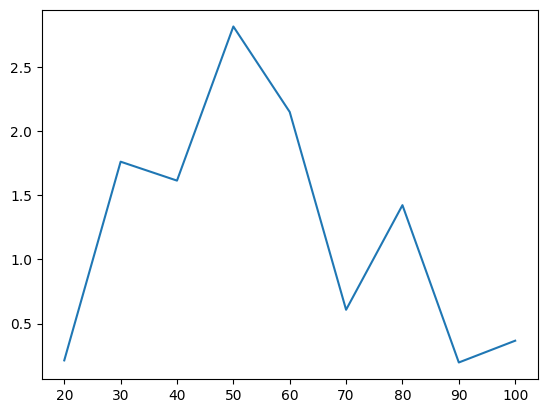

In [16]:
plt.plot(number_of_measurements, [a/r for a,r in zip(psa_rotation, psg_rotation)])

In [17]:
results

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18.64047622680664
        x: [ 1.000e+02  1.082e-01  2.213e+00 -5.615e-01  2.211e+00
             1.097e-02  1.575e+00]
      nit: 14
      jac: [ 0.000e+00 -6.755e+01  1.287e+01  2.120e+01 -1.044e+01
             2.213e+00 -1.240e+00]
     nfev: 71
     njev: 71
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>

In [18]:
def poor_wrap(th):

    while th > 2 * np.pi:
        th -= 2 * np.pi

    return th

def print_results(results):
    x = results.x
    g = rev_cond(x)
    g0 = rev_cond(x0)
    
    print('DRRP Configuration')
    print('-'*20)
    print(f'Number of Measurements = {x[0]}')
    print(f'Angular Increment PSG, deg = {np.degrees(poor_wrap(x[1]))}')
    print(f'Retardance PSG, deg = {np.degrees(x[2])}')
    print(f'Angular Increment PSA, deg = {np.degrees(poor_wrap(x[3]))}')
    print(f'Retardance PSA, deg = {np.degrees(x[4])}')
    print(f'Polarizer angle PSG, deg = {np.degrees(x[5])}')
    print(f'Polarizer angle PSA, deg = {np.degrees(x[6])}')
    print('-'*20)
    print('')
    print('DRRP Sensitivities Before Optimization')
    print('-'*20)
    print(f'Number of Measurements = {g0[0]}')
    print(f'Angular Increment PSG, deg = {g0[1]}')
    print(f'Retardance PSG, deg = {g0[2]}')
    print(f'Angular Increment PSA, deg = {g0[3]}')
    print(f'Retardance PSA, deg = {g0[4]}')
    print(f'Polarizer angle PSG, deg = {g0[5]}')
    print(f'Polarizer angle PSA, deg = {g0[6]}')
    print('')
    print('DRRP Sensitivities After Optimization')
    print('-'*20)
    print(f'Number of Measurements = {g[0]}')
    print(f'Angular Increment PSG, deg = {g[1]}')
    print(f'Retardance PSG, deg = {g[2]}')
    print(f'Angular Increment PSA, deg = {g[3]}')
    print(f'Retardance PSA, deg = {g[4]}')
    print(f'Polarizer angle PSG, deg = {g[5]}')
    print(f'Polarizer angle PSA, deg = {g[6]}')
    print('')

    

In [19]:
print_results(results)

TypeError: jacrev requires real- or complex-valued inputs (input dtype that is a sub-dtype of np.inexact), but got int32. If you want to use Boolean- or integer-valued inputs, use vjp or set allow_int to True.

In [ ]:
x0 = 215
x = 0
for _ in range(10):
    print(np.degrees(poor_wrap(np.radians(x))))
    x += x0

0.0
215.0
69.999985
285.0
140.0
354.99994
209.99994
64.99985
279.99988
134.99986
